# Some testing file for package

In [13]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

In [2]:
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader

# Part 1: get the cifar10 running

In [3]:
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# loading data
def load_CIFAR10_dataset():
    transform = torchvision.transforms.ToTensor()
    cifar10_path = './data'
    cifar10_train = torchvision.datasets.CIFAR10(root=cifar10_path, train=True, transform=transform, download=True)
    cifar10_test = torchvision.datasets.CIFAR10(root=cifar10_path, train=False, transform=transform)
    cifar10_splitted_train, cifar10_validation = torch.utils.data.random_split(
        cifar10_train, [45000, 5000], generator=torch.Generator().manual_seed(42))
    return (cifar10_train, cifar10_test, cifar10_splitted_train, cifar10_validation)

In [5]:
# dataloaders for the MNIST dataset
def construct_dataloaders(dataset, batch_size, shuffle_train=True):
    train_dataset, test_dataset, splitted_train_dataset, validation_dataset = dataset
    train_dataloader = DataLoader(train_dataset,
                                batch_size = batch_size,
                                shuffle = shuffle_train,)
    test_dataloader = DataLoader(test_dataset,
                                batch_size = 100,
                                shuffle = False,)
    splitted_train_dataloader = DataLoader(splitted_train_dataset,
                                batch_size = batch_size,
                                shuffle = shuffle_train,)
    validation_dataloader = DataLoader(validation_dataset,
                                batch_size = 100,
                                shuffle = False,)

    dataloaders = {}
    dataloaders['train'] = train_dataloader
    dataloaders['test'] = test_dataloader
    dataloaders['splitted_train'] = splitted_train_dataloader
    dataloaders['validation'] = validation_dataloader
    return dataloaders

In [6]:
dataset = load_CIFAR10_dataset()
dataloaders = construct_dataloaders(dataset, 100, shuffle_train=True)

Files already downloaded and verified


In [14]:
class Conv_Forward(nn.Module):
    def __init__(self, in_channels, out_channels, dropout):
        super(Conv_Forward, self).__init__()
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.fc(x)

In [15]:
class Teacher(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv, num_classes, dropout):
        super(Teacher, self).__init__()
        self.num_conv = num_conv
        self.conv_1 = nn.Conv2d(in_channels, out_channels, padding=1, kernel_size=3)
        self.activation = nn.LeakyReLU()
        self.drop_1 = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            *[
                Conv_Forward(out_channels, out_channels, dropout=dropout)
                for i in range(num_conv)
            ]
        )
        self.classifier = nn.Sequential(
            nn.Linear(out_channels, 30),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(30, num_classes)
        )

    def forward(self, x):
        out_1 = self.drop_1(self.activation(self.conv_1(x)))
        out_2 = self.fc(out_1)
        out_3 = torch.mean(out_2, dim=(2, 3))
        out_4 = self.classifier(out_3)
        return out_4

In [7]:
class Student(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes, dropout):
        super(Student, self).__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Dropout()
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Dropout()
        )

        self.classifier = nn.Sequential(
            nn.Linear(out_channels, 30),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(30, num_classes)
        )
        
    def forward(self, x):
        out_1 = self.conv_1(x)
        out_2 = self.conv_2(out_1)
        out_3 = torch.mean(out_2, dim=(2, 3))  
        out_4 = self.classifier(out_3)
        
        return out_4

In [8]:
@torch.no_grad()
def evaluate_model(dataloader, model, loss_fn):
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y_hat = model(X)
            loss += loss_fn(y_hat, y).item()
            accuracy += (y_hat.argmax(1) == y).type(torch.float).sum().item()
    loss = loss / len(dataloader.dataset)
    accuracy = accuracy / len(dataloader.dataset)
    return (loss, accuracy)

In [34]:
def train(dataloaders, model, loss_fn, optimizer, epochs, path, require_validation=True):
    # Load all data as dataloaders
    if require_validation:
        train_dataloader = dataloaders['splitted_train']
        validation_dataloader = dataloaders['validation']
    else:
        train_dataloader = dataloaders['train']    
    test_dataloader = dataloaders['test']
    
    # Prepare all lose and error
    train_loss, train_acc, validation_acc = [], [], []
    result = {}
    
    # Evaluate the model before training
    model.train()
    model.eval()
    tr_loss, tr_accuracy = evaluate_model(train_dataloader, model, loss_fn)
    va_loss, va_accuracy = evaluate_model(validation_dataloader, model, loss_fn)
    train_loss.append(copy.deepcopy(tr_loss))
    train_acc.append(copy.deepcopy(tr_accuracy))
    validation_acc.append(copy.deepcopy(va_accuracy))
    
    # Training epochs
    for i in tqdm(range(epochs)):
        model.train()
        for X, y in train_dataloader:
            optimizer.zero_grad()
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()
        
        # Evaluate the model after each epoch
        model.eval()   
        tr_loss, tr_accuracy = evaluate_model(train_dataloader, model, loss_fn)
        va_loss, va_accuracy = evaluate_model(validation_dataloader, model, loss_fn)
        train_loss.append(copy.deepcopy(tr_loss))
        train_acc.append(copy.deepcopy(tr_accuracy))
        validation_acc.append(copy.deepcopy(va_accuracy))
        
        if ((i+1) % 10) == 0:
            filepath = path + f'epoch_{i}.bin'
            torch.save(model.state_dict(), filepath)
        
    # Collect final results    
    result['train_loss'] = train_loss
    result['train_accuracy'] = train_acc
    result['validation_accuracy'] = validation_acc
    
    try:
        result_file_name = path + f'result_epoch_{epochs}.json'
        with open(result_file_name, 'w') as f:
            json.dump(result, f)
    except:
        pass

    return model, result

In [10]:
student_model = Student(3, 32, 10, 0.2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(student_model.parameters(), lr = 0.001, momentum = 0.99)
epochs = 100
path = 'model/cifar10_github/'

In [11]:
model, result = train(dataloaders, student_model, loss_fn, optimizer, epochs, path, require_validation=True)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:46:18<00:00, 63.79s/it]


NameError: name 'json' is not defined

In [21]:
def plot_model_performance(result, num_epoch):
    # Creating subplots for each performance metric
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    epochs = range(num_epoch+1)
    def add_value_labels(ax, data_points):
        for i, value in enumerate(data_points):
            ax.text(i, value, f"{value:.6f}", ha='center', va='bottom')
            
    # Train Loss
    axs[0].plot(epochs, result['train_loss'], marker='o', color='tab:red', label='Train Loss')
    axs[0].set_title('Train Loss Over Epochs')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_xticks(epochs)
    axs[0].grid(True)
    add_value_labels(axs[0], result['train_loss'])
    axs[0].legend()
    
    # Train Accuracy
    axs[1].plot(epochs, result['train_accuracy'], marker='s', color='tab:blue', label='Train Accuracy')
    axs[1].set_title('Train Accuracy Over Epochs')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Train Accuracy')
    axs[1].set_xticks(epochs)
    axs[1].grid(True)
    add_value_labels(axs[1], result['train_accuracy'])
    axs[1].legend()
    
    # Validation Accuracy
    axs[2].plot(epochs, result['validation_accuracy'], marker='^', color='tab:green', label='Validation Accuracy')
    axs[2].set_title('Validation Accuracy Over Epochs')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Validation Accuracy')
    axs[2].set_xticks(epochs)
    axs[2].grid(True)
    add_value_labels(axs[2], result['validation_accuracy'])
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()

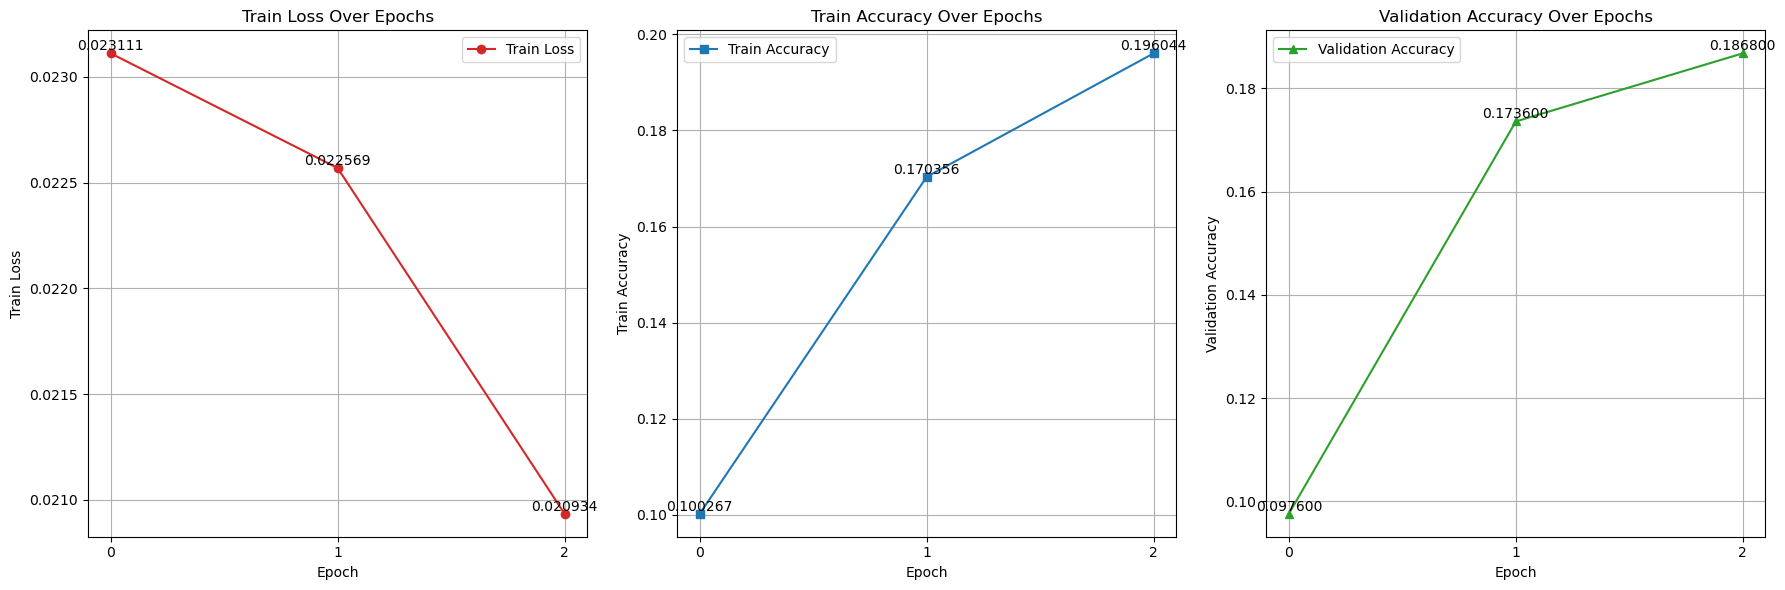

In [48]:
plot_model_performance(result, num_epoch = 2)

In [ ]:
# 65s per epoch
# 23% for 5 epochs of training
# 34% for 15 epochs of training
# 39% for 25 epochs of training
# 42% for 35 epochs of training

In [35]:
teacher_model = Teacher(3, 32, 4, 10, 0.2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(teacher_model.parameters(), lr = 0.001, momentum = 0.99)
epochs = 100
path = 'model/cifar10_teacher_github/'

In [36]:
model, result = train(dataloaders, teacher_model, loss_fn, optimizer, epochs, path, require_validation=True)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [6:01:07<00:00, 216.67s/it]


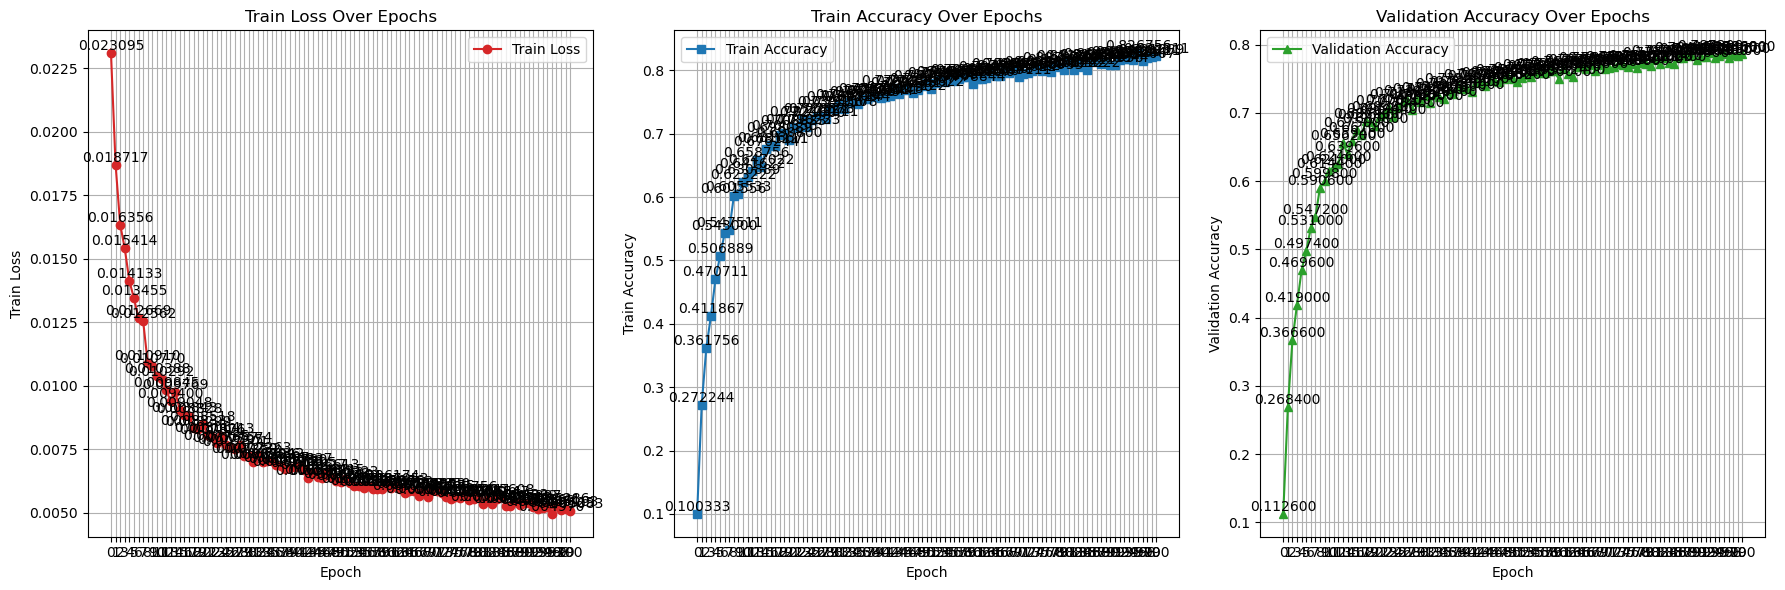

In [37]:
plot_model_performance(result, num_epoch = 100)

In [39]:
student_model_adamW = Student(3, 32, 10, 0.2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(student_model_adamW.parameters(), lr = 0.001)
epochs = 100
path = 'model/cifar10_student_AdamW_github/'

In [40]:
model, result = train(dataloaders, student_model_adamW, loss_fn, optimizer, epochs, path, require_validation=True)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:44:25<00:00, 62.65s/it]


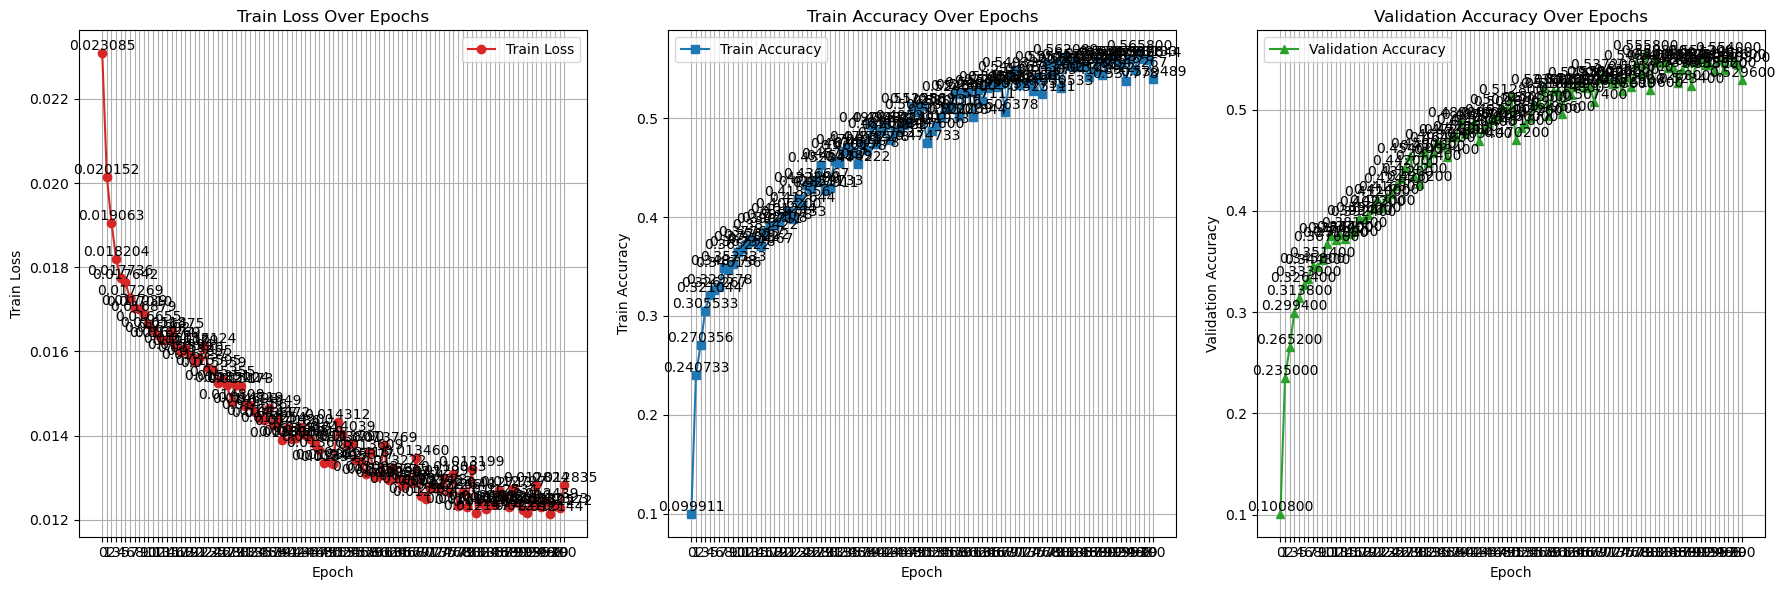

In [41]:
plot_model_performance(result, num_epoch = 100)

In [45]:
student_model_adam = Student(3, 32, 10, 0.2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(student_model_adam.parameters(), lr = 0.001)
epochs = 100
path = 'model/cifar10_student_Adam_github/'

In [46]:
model, result = train(dataloaders, student_model_adam, loss_fn, optimizer, epochs, path, require_validation=True)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:44:19<00:00, 62.59s/it]


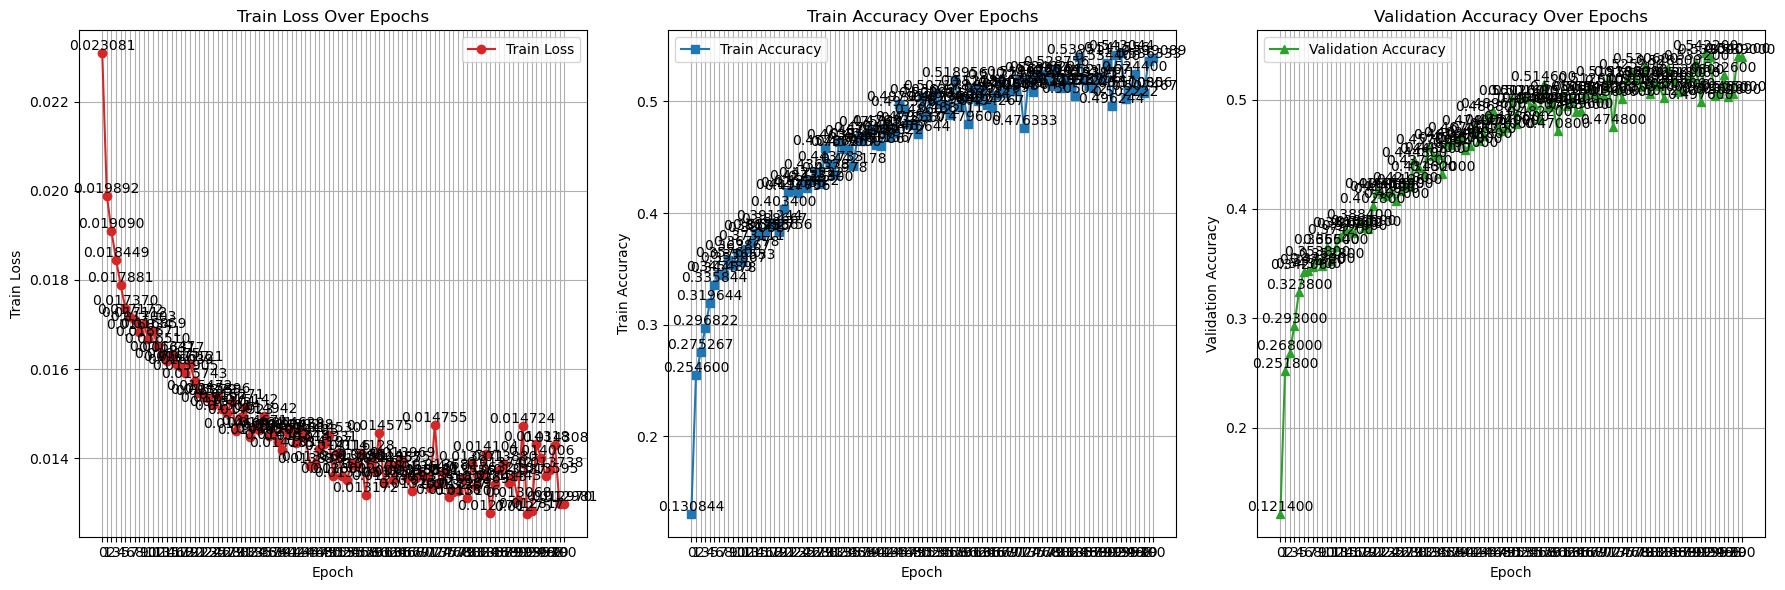

In [47]:
plot_model_performance(result, num_epoch = 100)

In [26]:
# Load from file
with open('model/cifar10_github/result_epoch_100.json', 'r') as f:
    result = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'model/cifar10_github/result_epoch_100.json'

# Part 2: Train function

In [39]:
def train_tsm():
    # do we need a class object?
    '''
    Try to figure out what do we need
    1. train teacher model, student model and teacher-student model
    2. train just teacher model and teacher-student model
    3. train teacher-student model based on a pretrain teacher model

    Return:
    Save all the model trained
    Save training wall clock time 
    The performance/metrics during the training (per epoch)
    

    Input:

    train_teacher: Boolean, whether we need to train the teacher model
    train_student: Boolean, whether we need to train the student model
    teacher_pretrain: Boolean, whether we have a pretrain input

    dataloaders: any data related stuff. Let's assume all models are trained on the same data

    teacher_model: nn.module, a defined structure of model (or a pretrain model)
    teacher_epochs: int, the epoch of training for teacher model
    teacher_loss_fn: nn.F, the loss function used to train teacher model
    teacher_optimizer: torch.optim, the optimizer used to train teacher model

    student_model: nn.module, a defined structure of model
    student_epochs: int, the epoch of training for student model
    student_loss_fn: nn.F, the loss function used to train student model
    student_optimizer: torch.optim, the optimizer used to train student model

    teacher_student_model: nn.module
    teacher_student_epochs: int, the epoch of training for teacher-student model
    teacher_student_loss_fn: nn.F, the loss function used to train teacher-student model. Might need to add more hyperparamters here
    teacher_student_loss_fn_alpha: a parameter for mixed loss, which can go to the input of teacher_student_loss_fn
    teacher_student_optimizer: torch.optim, the optimizer used to train teacher-student model

    path: where to save the model
    path_config/info_config: some info regarding the config of this training
    
    '''

    return

# Part 3: Some util functions

In [ ]:
def get_model_config(list_of_path):
    '''
    
    '''


def get_model_result(list_of_path):
    '''
    
    '''


def inference_time(model, batch_list, experiment_time):
    '''
    For a given model, return the average inference wall clock time of one sample in one epoch for different batch size
    the batch size might affect the average speed? we can make an experiment to find out

    batch_list: a list of batch size we consider when using model(X)
    experiment_time: the number of trials
    '''

def plot_inference_time(model_inference_time, batch_list):
    '''
    plot the inference time for different models on different batch size values. 
    optional: adding max and min of each model in different trials
     ! should be easy for chatgpt once we give it an example input
    '''

